In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM as GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from scipy.spatial.distance import cdist, pdist
import matplotlib.cm as cm


%matplotlib inline

In [2]:
from sklearn.cluster import DBSCAN

# Question 1

The following data comes from a larger set detailing every motor vehicle collision in NYC (https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95). This particular subset only considers collisions that occurred on October 31, 2017.

You have 680 collision records in the file ‘NYPD_Motor_Vehicle_Collisions_Duplicates.csv’, but you realize that some of these are actually duplicates resulting from a technical error. You know that there are approximately 620 unique records in the file, but you want to determine the exact number.

In [3]:
collision_df = pd.read_csv('data/NYPD_Motor_Vehicle_Collisions_Duplicates.csv').fillna('')
collision_df.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,10/31/2017,0:00,,,40.7331,-73.9548,"(40.733135, -73.954765)",MANHATTAN AVENUE,,,...,Unspecified,,,,3781862,PICK-UP TRUCK,PICK-UP TRUCK,,,
1,10/31/2017,0:00,,,40.7535,-73.8979,"(40.75351, -73.8979)",,,,...,Unspecified,,,,3781130,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,,,
2,10/31/2017,0:00,MANHATTAN,10036,40.7597,-73.9917,"(40.759727, -73.99169)",WEST 44 STREET,9 AVENUE,,...,,,,,3781009,PASSENGER VEHICLE,,,,
3,10/31/2017,0:00,BROOKLYN,11207,,,,LINDEN BOULEVARD,WILLIAMS AVENUE,,...,Unspecified,,,,3780501,PASSENGER VEHICLE,DS,,,
4,10/31/2017,0:00,MANHATTAN,10030,40.8156,-73.9435,"(40.81561, -73.943474)",,,2309 7 AVENUE,...,Unspecified,Unspecified,,,3780511,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,PASSENGER VEHICLE,,


In [4]:
collision_df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

a) Factorize the dataset such that all the columns contain floating point values

In [5]:
columns = ['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5']

collision_fc = pd.DataFrame()

for c in columns:
    x = pd.factorize(collision_df[c])
    collision_fc[c] = x[0]


In [6]:
collision_fc.tail()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
675,0,288,0,0,3,3,3,73,240,0,...,0,0,0,0,613,2,1,0,0,0
676,0,289,3,5,542,541,543,166,146,0,...,1,0,0,0,614,1,2,0,0,0
677,0,290,0,0,3,3,3,209,0,0,...,0,1,0,0,615,2,4,1,0,0
678,0,290,1,46,543,542,544,1,0,147,...,0,0,0,0,616,2,4,0,0,0
679,0,290,0,0,3,3,3,209,0,0,...,0,1,0,0,615,2,4,1,0,0


b) Using DBSCAN(eps=0.1, min_samples=1), find the number of clusters in this dataset.

In [7]:

res_d = DBSCAN(eps=0.1, min_samples=1).fit(collision_fc)
#res_d.labels_
n_clusters_ = len(set(res_d.labels_)) - (1 if -1 in res_d.labels_ else 0)
n_clusters_

617

c) Use K = [600, 680] and test if the number of clusters holds using KMeans. (Hint: we will have to use the score() function from KMeans in this case to find duplicates after factorizing the string variables. When we reach the point a score of 0, this means that each unique observation has its own cluster, so n_clusters is equal to the number of unique observations.)

In [8]:
# Code here
#K = [600,680]
from sklearn.cluster import KMeans
for k in range(600,681):
    km = KMeans(random_state=1,n_clusters=k)
    res_k = km.fit(collision_fc)
    score = res_k.score(collision_fc)
    if score == 0:
        print(k)
        break

617


d) Confirm the number of unique records by using a more straightforward technique to identify duplicate rows (hint: Use drop_duplicates() from pandas). 

In [9]:
# Code here
collision_fc = pd.DataFrame.drop_duplicates(collision_fc)
print (len(collision_fc))

617


# Question 2

## Data Guideline
The stop-question-and-frisk program, or stop-and-frisk, in New York City, is a practice of the New York City Police Department in which police officers stop and question a pedestrian, then frisk them for weapons and other contraband; this is what is known in other places in the United States as the Terry stop. The rules for stop, question, and frisk are found in the state's criminal procedure law section 140.50, and are based on the decision of the United States Supreme Court in the case of Terry v. Ohio. About 685,724 people were stopped in 2011. However, the number of stops has been reduced dramatically since then, to 22,939 in 2015. Stop-and-frisk got increased attention in the 2016 presidential debate.

In [10]:
stop_df = pd.read_csv('data/stop_2012.csv', index_col='zipcode')
stop_df.head()

,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,month_December,...,month_May,month_November,month_October,month_September,time_1,time_2,time_3,time_4,time_5,time_6
zipcode,,,,,,,,,,,,,,,,,,,,,
10472,278.0,212.0,315.0,213.0,254.0,234.0,241.0,158.0,95.0,142.0,...,104.0,96.0,110.0,123.0,349.0,35.0,57.0,206.0,437.0,663.0
10037,199.0,79.0,301.0,154.0,163.0,137.0,147.0,114.0,114.0,34.0,...,67.0,53.0,65.0,96.0,271.0,38.0,32.0,143.0,248.0,448.0
10460,278.0,169.0,283.0,203.0,234.0,197.0,289.0,117.0,133.0,91.0,...,95.0,86.0,148.0,175.0,462.0,51.0,56.0,190.0,411.0,483.0
11224,175.0,82.0,177.0,176.0,180.0,179.0,206.0,112.0,67.0,134.0,...,112.0,23.0,68.0,68.0,157.0,27.0,37.0,97.0,282.0,575.0
10456,979.0,647.0,1086.0,773.0,913.0,814.0,885.0,709.0,465.0,290.0,...,518.0,395.0,521.0,511.0,1295.0,137.0,110.0,662.0,1553.0,2340.0


# a) Find the zip code with most stops

In [11]:
stop_df.columns

Index(['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'time_1',
       'time_2', 'time_3', 'time_4', 'time_5', 'time_6'],
      dtype='object')

In [12]:
#subs = stop_df[stop_df.columns[8:20]]

In [13]:
vals = []
for i, row in stop_df.iterrows():
    vals.append(sum(row))
stop_df['sum'] = vals

In [14]:
stop_df = stop_df.reset_index()
stop_df.head()

,zipcode,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,...,month_November,month_October,month_September,time_1,time_2,time_3,time_4,time_5,time_6,sum
0,10472,278.0,212.0,315.0,213.0,254.0,234.0,241.0,158.0,95.0,...,96.0,110.0,123.0,349.0,35.0,57.0,206.0,437.0,663.0,5241.0
1,10037,199.0,79.0,301.0,154.0,163.0,137.0,147.0,114.0,114.0,...,53.0,65.0,96.0,271.0,38.0,32.0,143.0,248.0,448.0,3540.0
2,10460,278.0,169.0,283.0,203.0,234.0,197.0,289.0,117.0,133.0,...,86.0,148.0,175.0,462.0,51.0,56.0,190.0,411.0,483.0,4959.0
3,11224,175.0,82.0,177.0,176.0,180.0,179.0,206.0,112.0,67.0,...,23.0,68.0,68.0,157.0,27.0,37.0,97.0,282.0,575.0,3525.0
4,10456,979.0,647.0,1086.0,773.0,913.0,814.0,885.0,709.0,465.0,...,395.0,521.0,511.0,1295.0,137.0,110.0,662.0,1553.0,2340.0,18291.0


In [15]:
stop_df['zipcode'].loc[stop_df['sum'].idxmax()]

10456

## so the zipcode with most stop is 10456

We will normalize the data using MinMax Scaling

In [16]:
min_max_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(stop_df), columns=stop_df.columns, index=stop_df.index)

In [17]:
df_scaled.head()

,zipcode,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,...,month_November,month_October,month_September,time_1,time_2,time_3,time_4,time_5,time_6,sum
0,0.277712,0.283963,0.327666,0.290055,0.275550,0.278204,0.287469,0.272316,0.222849,0.204301,...,0.243038,0.211132,0.240705,0.269498,0.255474,0.268868,0.290550,0.281391,0.283333,0.286300
1,0.021226,0.203269,0.122102,0.277164,0.199224,0.178532,0.168305,0.166102,0.160790,0.245161,...,0.134177,0.124760,0.187867,0.209266,0.277372,0.150943,0.201693,0.159691,0.191453,0.193273
2,0.270637,0.283963,0.261206,0.260589,0.262613,0.256298,0.242015,0.326554,0.165021,0.286022,...,0.217722,0.284069,0.342466,0.356757,0.372263,0.264151,0.267983,0.264649,0.206410,0.270878
3,0.721108,0.178754,0.126739,0.162983,0.227684,0.197152,0.219902,0.232768,0.157969,0.144086,...,0.058228,0.130518,0.133072,0.121236,0.197080,0.174528,0.136812,0.181584,0.245726,0.192453
4,0.268278,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.518868,0.933709,1.000000,1.000000,1.000000


# b) Implement both the elbow method and silhouette method score to decide the number of clusters K. Use the range K = [2, 10] when constructing the visualization. Note that you should be choosing your choice of K for later problems based on the silhouette score.

In [18]:
'''K mean'''


def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

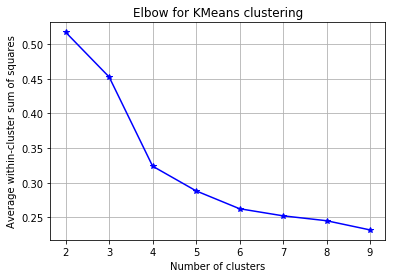

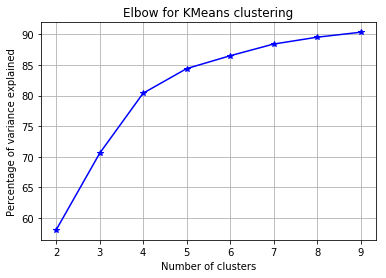

In [19]:
elbow(df_scaled, range(2,10))

In [20]:
'''Silhouette'''


range_n_clusters = [i for i in range(2,11)]

for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(df_scaled)
    #report average Silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.6407753818634357
For n_clusters =3, the average silhouette_score is :0.5331638065522558
For n_clusters =4, the average silhouette_score is :0.5232122214459508
For n_clusters =5, the average silhouette_score is :0.5262375346127519
For n_clusters =6, the average silhouette_score is :0.5297510592532817
For n_clusters =7, the average silhouette_score is :0.5310017432899332
For n_clusters =8, the average silhouette_score is :0.5310943714477739
For n_clusters =9, the average silhouette_score is :0.5289361184541361
For n_clusters =10, the average silhouette_score is :0.5144163030601495


# according to the silhouette score above, the appropriate k is 2

# c) Use that value of K from (b) for a Gaussian Mixture and KMeans model. Then store the results in a dataframe/dictionary along with the zipcodes it maps to.

In [21]:
k = 2
# Gaussian Mixture model

gm = GaussianMixture(n_components = k, random_state=522)
res_g = gm.fit(df_scaled)
y_g = gm.predict(df_scaled)
print (y_g)


[1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
#KMeans model

#initialize the model
km=KMeans(random_state = 1,n_clusters = k)

res_2k=km.fit(df_scaled) #train the model
y_k=res_2k.labels_
print(y_k) #output the result
# print res.predict(X) #alternative - one can pass this or other data to cluster according to the model trained (centroids) 

[0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


d) Visualize the results from the Gaussian Mixture Model and KMeans on the map with the function below. Make sure your results from (c) has the right form:
```Python
result = {
    11374: 1,
    11373: 0,
    ...
}
```

1. Make sure your result from (c) is in the correct form
2. Make sure NY.shp, NY.shx, NY.dbf are downloaded in your working directory
3. Use the defined function plot_on_map(your_result)

In [23]:
import geopandas as gpd
NYCzip = gpd.read_file('data/NY.shp')

In [24]:
colors=['green','blue','red','yellow','magenta']
def plot_on_map(gdf,Y,x_label = 'long',y_label = 'lat',title = 'map by zip'): #take geopandas dataframe gdf with zip code shapefiles and the dictionary mapping zip codes to clusters
    #visualize zip codes using clusters for picking colors        
    f, ax = plt.subplots(1, figsize=(12, 12)) 
    
    for c in range(max(Y.values())+1): #for each cluster
        gdf.loc[gdf.zipcode.map(Y)==c].plot(ax=ax, color=colors[c], legend=True)
        leg = ax.get_legend()
    plt.legend()
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    

In [25]:
#1. make sure your result from (c)
zipcode = stop_df['zipcode']

In [26]:
dic_g = dict(zip(zipcode,y_g))
dic_k = dict(zip(zipcode,y_k))

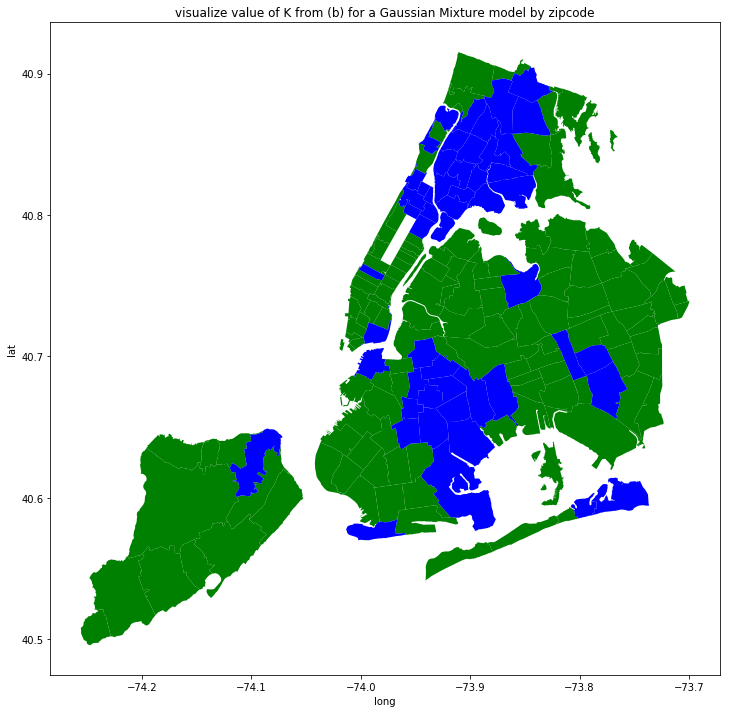

In [27]:
title_1 = 'visualize value of K from (b) for a Gaussian Mixture model by zipcode' 
plot_on_map(NYCzip,dic_g,title = title_1)

Figure1. This is a map of guassian mixture model on stop-question-and-frisk program in NYC. There are 2 clusters in this program, green is k = 0, blue is k = 1.

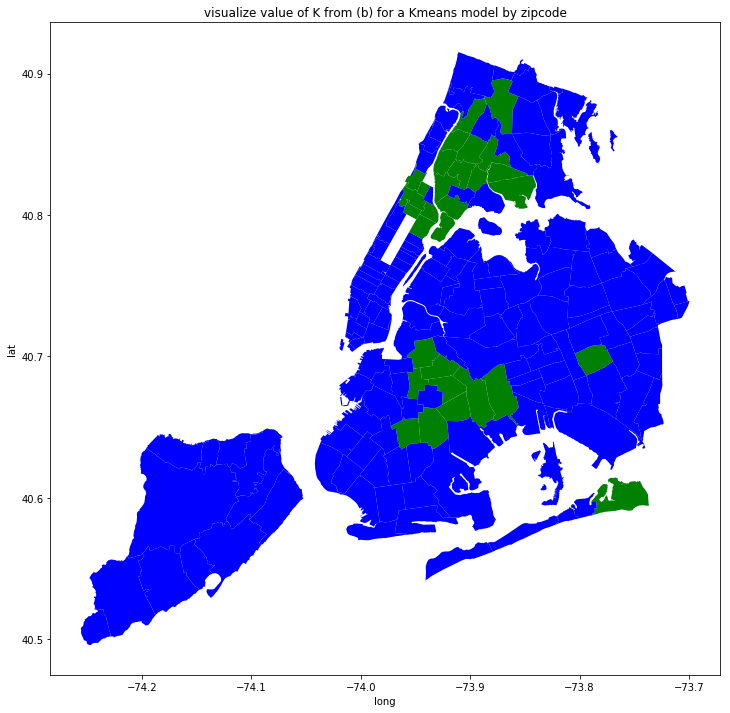

In [28]:
title_2 = 'visualize value of K from (b) for a Kmeans model by zipcode'
plot_on_map(NYCzip, dic_k, title = title_2)


Figure2. This is a map of guassian mixture model on stop-question-and-frisk program in NYC. There are 2 clusters in this program, green is k = 0, blue is k = 1.